# TEST Orientation

Attempting to fix the orientation issues of sampling functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset, iUSDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

In [3]:
patient_id = "003" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [4]:
UR = UltrasoundRenderer(128)

In [5]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "Patient 5", axis=0)

T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

T1_volume = T1_volume.float()

T1_data = pd.DataFrame(
    {"organ": ["fat","liver","muscle","BWM","BGM","CSF","AIR"],
     "intensity": [260,500,870,780,920,2500, 0], 
     "impedance": [1.34e6,1.67e6,1.68e6,1.6e6,1.6e6,1.5e6, 0.0004e6]}
)

t1 = T1_data['intensity'].values.reshape(-1,1)
z1 = T1_data['impedance'].values.reshape(-1,1)

t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

In [7]:
UR = UltrasoundRenderer(220, 0.0001)
angle = 27//2  # degrees
rays = 150
thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
source = np.array([260, 100, 150])  # source position

source = torch.Tensor([ 68.1002, 290.1414, 130.0000])
directions  = torch.Tensor([[-0.1058, -0.9944,  0.0000],
        [-0.0913, -0.9958,  0.0000],
        [-0.0768, -0.9970,  0.0000],
        [-0.0623, -0.9981,  0.0000],
        [-0.0478, -0.9989,  0.0000],
        [-0.0333, -0.9994,  0.0000],
        [-0.0188, -0.9998,  0.0000],
        [-0.0042, -1.0000,  0.0000],
        [ 0.0103, -0.9999,  0.0000],
        [ 0.0248, -0.9997,  0.0000],
        [ 0.0394, -0.9992,  0.0000],
        [ 0.0539, -0.9985,  0.0000],
        [ 0.0684, -0.9977,  0.0000],
        [ 0.0829, -0.9966,  0.0000],
        [ 0.0974, -0.9952,  0.0000],
        [ 0.1118, -0.9937,  0.0000],
        [ 0.1263, -0.9920,  0.0000],
        [ 0.1407, -0.9901,  0.0000],
        [ 0.1550, -0.9879,  0.0000],
        [ 0.1694, -0.9856,  0.0000],
        [ 0.1837, -0.9830,  0.0000],
        [ 0.1980, -0.9802,  0.0000],
        [ 0.2122, -0.9772,  0.0000],
        [ 0.2264, -0.9740,  0.0000],
        [ 0.2405, -0.9707,  0.0000],
        [ 0.2546, -0.9671,  0.0000],
        [ 0.2686, -0.9632,  0.0000],
        [ 0.2826, -0.9592,  0.0000],
        [ 0.2965, -0.9550,  0.0000],
        [ 0.3103, -0.9506,  0.0000],
        [ 0.3241, -0.9460,  0.0000],
        [ 0.3378, -0.9412,  0.0000],
        [ 0.3515, -0.9362,  0.0000],
        [ 0.3651, -0.9310,  0.0000],
        [ 0.3786, -0.9256,  0.0000],
        [ 0.3920, -0.9200,  0.0000],
        [ 0.4053, -0.9142,  0.0000],
        [ 0.4185, -0.9082,  0.0000],
        [ 0.4317, -0.9020,  0.0000],
        [ 0.4448, -0.8956,  0.0000],
        [ 0.4577, -0.8891,  0.0000],
        [ 0.4706, -0.8823,  0.0000],
        [ 0.4834, -0.8754,  0.0000],
        [ 0.4961, -0.8683,  0.0000],
        [ 0.5086, -0.8610,  0.0000],
        [ 0.5211, -0.8535,  0.0000],
        [ 0.5334, -0.8458,  0.0000],
        [ 0.5457, -0.8380,  0.0000],
        [ 0.5578, -0.8300,  0.0000],
        [ 0.5698, -0.8218,  0.0000],
        [ 0.5817, -0.8134,  0.0000],
        [ 0.5935, -0.8049,  0.0000],
        [ 0.6051, -0.7962,  0.0000],
        [ 0.6166, -0.7873,  0.0000],
        [ 0.6280, -0.7782,  0.0000],
        [ 0.6392, -0.7690,  0.0000],
        [ 0.6503, -0.7596,  0.0000],
        [ 0.6613, -0.7501,  0.0000],
        [ 0.6721, -0.7404,  0.0000],
        [ 0.6828, -0.7306,  0.0000],
        [ 0.6934, -0.7206,  0.0000],
        [ 0.7038, -0.7104,  0.0000],
        [ 0.7140, -0.7001,  0.0000],
        [ 0.7241, -0.6897,  0.0000]]) 

start = 0.5 # offset in pixels (or in image units depending on scaling)

C:\Users\noe\AppData\Local\Temp\ipykernel_45384\27489506.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).



256 256 256
tensor([[[[[-0.4659,  1.2756,  0.0196]],

          [[-0.4667,  1.2678,  0.0196]],

          [[-0.4675,  1.2600,  0.0196]],

          ...,

          [[-0.6459, -0.4168,  0.0196]],

          [[-0.6468, -0.4246,  0.0196]],

          [[-0.6476, -0.4324,  0.0196]]],


         [[[-0.4659,  1.2756,  0.0196]],

          [[-0.4666,  1.2678,  0.0196]],

          [[-0.4673,  1.2600,  0.0196]],

          ...,

          [[-0.6213, -0.4192,  0.0196]],

          [[-0.6220, -0.4270,  0.0196]],

          [[-0.6227, -0.4348,  0.0196]]],


         [[[-0.4659,  1.2756,  0.0196]],

          [[-0.4665,  1.2678,  0.0196]],

          [[-0.4671,  1.2600,  0.0196]],

          ...,

          [[-0.5966, -0.4212,  0.0196]],

          [[-0.5972, -0.4291,  0.0196]],

          [[-0.5978, -0.4369,  0.0196]]],


         ...,


         [[[-0.4659,  1.2756,  0.0196]],

          [[-0.4604,  1.2700,  0.0196]],

          [[-0.4548,  1.2645,  0.0196]],

          ...,

          [[ 0.7320,

<Axes: title={'center': 'Fan-shaped Ultrasound Frame'}>

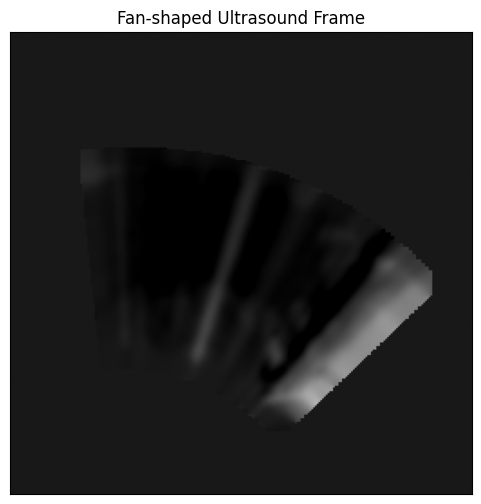

In [11]:
out_2 = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(source),
    directions=directions,
    artifacts=False,
    angle=angle,
    start=110,
    plot=True
)

out_2[1]
# x,y, intensities = out_2
# plt.scatter(
#     x,y,
#     c=intensities, cmap='gray', s=1, alpha=0.5
# )

In [ ]:
source_2 = torch.tensor([ 68.1002, 290.1414, 130.0000])

tensor([ 68.1002, 290.1414, 130.0000])

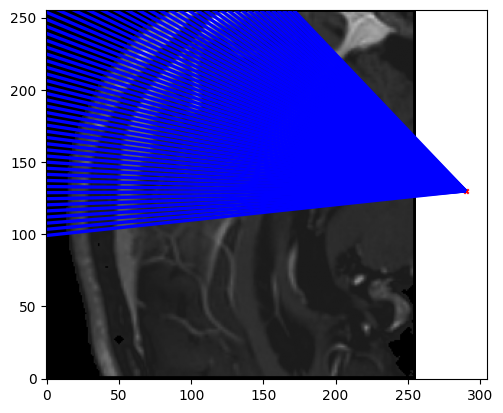

In [40]:
source_2 = torch.tensor([ 68., 290.1414, 130.0000])
# Fix directions_2 to have shape (64, 3) and reorder columns if needed
directions_2 = directions[:, [2, 1, 0]]

plt.imshow(Z_vol[68,:,:], 
           origin='lower', 
           cmap='gray')
plt.scatter(source[1], source[2], c='red', s=10, marker='x')
plt.quiver(
    source_2[1].repeat(directions.shape[0]),
    source_2[2].repeat(directions.shape[0]),
    directions_2[:, 1],
    directions_2[:, 2],
    angles='xy', scale_units='xy', scale=0.0001, color='blue'
)

[INFO] Variances: x=0.0000, y=4672.9849, z=1927.4108


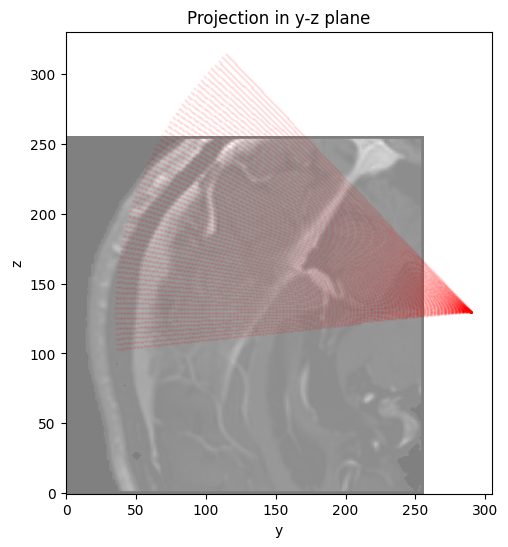

256 256 256
tensor([[[[[-0.4667,  1.2756,  0.0196]],

          [[-0.4667,  1.2678,  0.0188]],

          [[-0.4667,  1.2600,  0.0179]],

          ...,

          [[-0.4667, -0.6976, -0.1903]],

          [[-0.4667, -0.7054, -0.1912]],

          [[-0.4667, -0.7132, -0.1920]]],


         [[[-0.4667,  1.2756,  0.0196]],

          [[-0.4667,  1.2678,  0.0189]],

          [[-0.4667,  1.2600,  0.0182]],

          ...,

          [[-0.4667, -0.7004, -0.1616]],

          [[-0.4667, -0.7082, -0.1623]],

          [[-0.4667, -0.7160, -0.1630]]],


         [[[-0.4667,  1.2756,  0.0196]],

          [[-0.4667,  1.2678,  0.0190]],

          [[-0.4667,  1.2600,  0.0184]],

          ...,

          [[-0.4667, -0.7027, -0.1328]],

          [[-0.4667, -0.7106, -0.1334]],

          [[-0.4667, -0.7184, -0.1340]]],


         ...,


         [[[-0.4667,  1.2756,  0.0196]],

          [[-0.4667,  1.2700,  0.0251]],

          [[-0.4667,  1.2645,  0.0306]],

          ...,

          [[-0.4667,

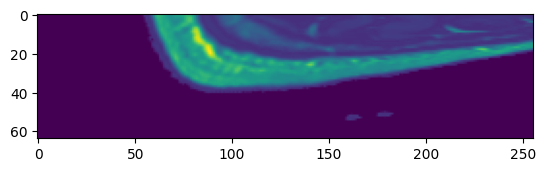

In [43]:
plt.imshow(UR.trace_ray(volume=Z_vol, 
             source=source_2, 
             directions=directions_2,
             num_samples=256,
             num_rays=64))

## Comparing to the US files

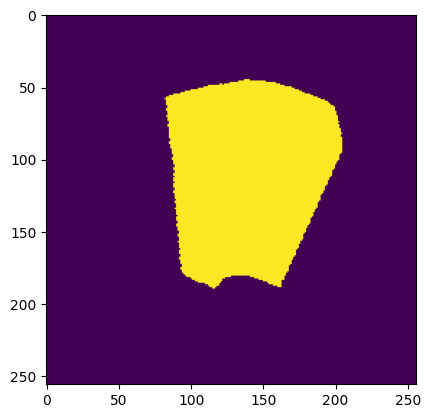

In [ ]:
plt.imshow(US.data[:, source[1], :]>0.) # to select the important region

[INFO] Tracing rays with source: tensor([260, 100, 150]) and directions shape: torch.Size([150, 1, 3])
[INFO] Starting from sample index: 110 (for instance, to skip bones)
[INFO] Padded output to start from sample index: 110 torch.Size([150, 221])
Intensity range: 0.0000 to 0.0011


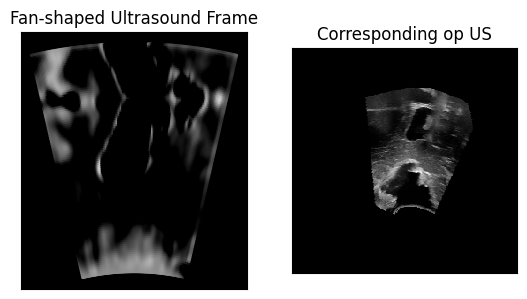

In [ ]:
US = iUSDataset(image_path / iUS_file, "iUS", axis=0)
fig, ax = plt.subplots(1,2)
_, scatter = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor(source),
    directions=directions,
    artifacts=False,
    angle=angle,
    ax=ax[0],
    start=start,
)
# change contrast
scatter.set_clim(vmin=-0.002)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(US.data[:,source[1],:], cmap='gray', interpolation='nearest', alpha=1)
ax[1].set_title("Corresponding op US")
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

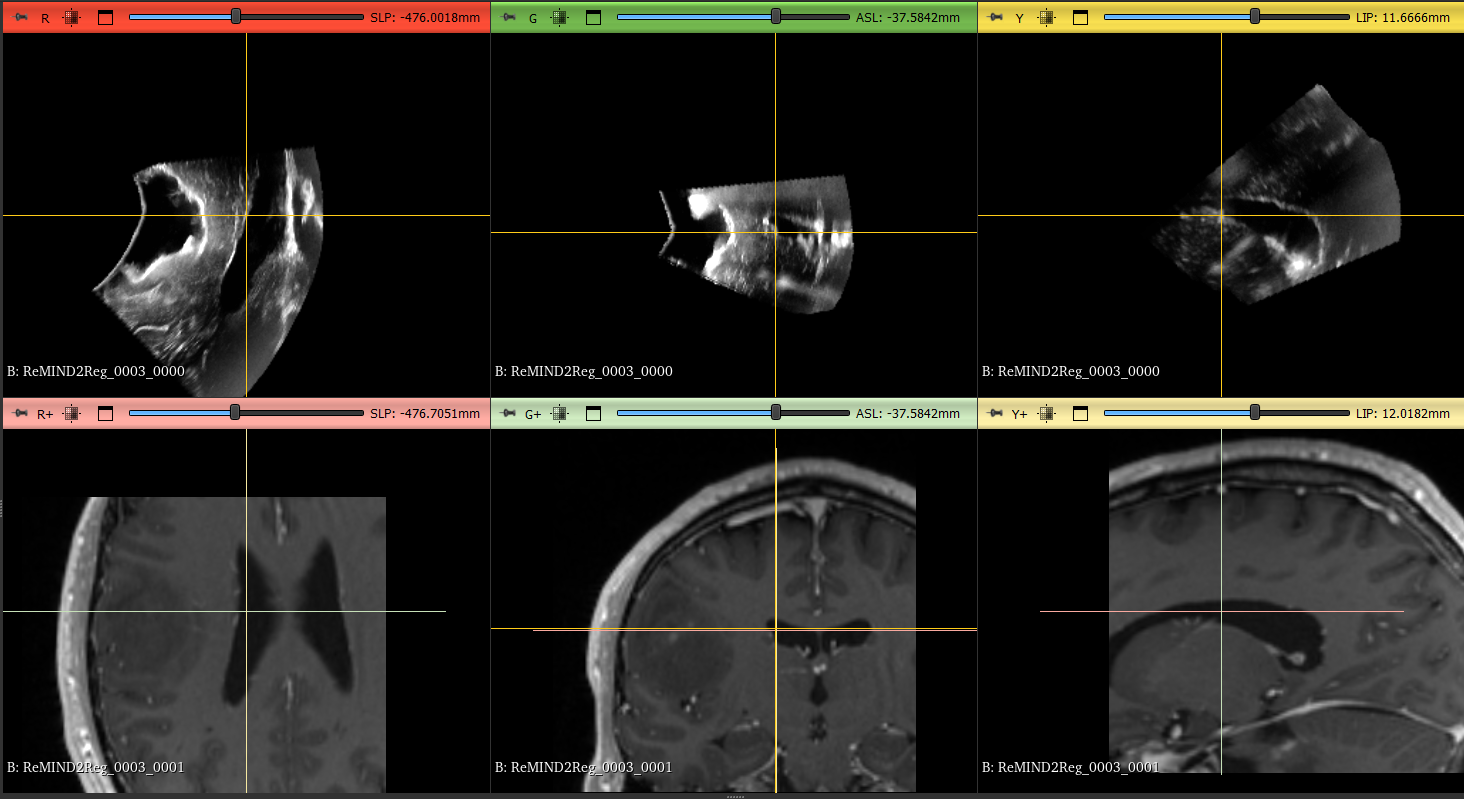

Here is the aligned US/MRI from whithin Slicer.